In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import sklearn.feature_selection as fs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
hcc_smarts_df = pd.read_csv("data/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt", sep = " ")
mcf_smarts_df = pd.read_csv("data/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", sep= " ")

from fix_data import add_label_T
hcc_smarts_df = add_label_T(hcc_smarts_df)
mcf_smarts_df = add_label_T(mcf_smarts_df)

X1 = hcc_smarts_df.loc[:,hcc_smarts_df.columns!='label']
X2 = mcf_smarts_df.loc[:,mcf_smarts_df.columns!='label']
y = mcf_smarts_df["label"]


# mcf_smarts_df
### PCA 2 components 

In [4]:
pca = PCA(n_components=2)
pca.fit(X2)

print(sum(pca.explained_variance_ratio_))
red_X2 = pd.DataFrame(pca.transform(X2))
red_X2

0.7066303312208582


,0,1
0,13131.081856,-12716.489155
1,-47422.754025,-24042.707166
2,94682.412774,-3885.918848
3,-46804.508372,-23673.963171
4,-37054.766246,-10017.024374
...,...,...
378,-30423.989675,258.437947
379,-5965.250695,102.228087
380,4265.961618,-21684.709634
381,41724.822448,-23590.325613


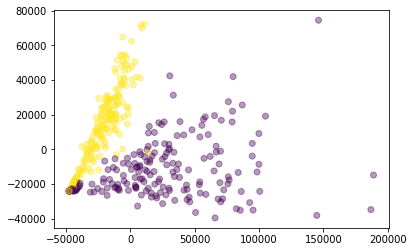

In [5]:
y = mcf_smarts_df["label"]
plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y)

In [6]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(red_X2, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [10]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

In [7]:
from sklearn.model_selection import cross_val_score

poly100_kernel_svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="poly", degree=10, coef0=100, C=5)
)
poly100_kernel_svm_clf.fit(red_X2, y)

poly_rmse = -cross_val_score(poly100_kernel_svm_clf, red_X2, y,
                              scoring="accuracy", cv=10)
poly_rmse
# fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

# plt.sca(axes[0])
# plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])

# plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y)

# plt.title("degree=3, coef0=1, C=5")



# plt.sca(axes[1])

# plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])

# plt.scatter(red_X2[0], red_X2[1], alpha=0.4, c=y)

# plt.title("degree=10, coef0=100, C=5")
# plt.ylabel("")

# plt.show()

# Sigmoid kernel

In [4]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X2)

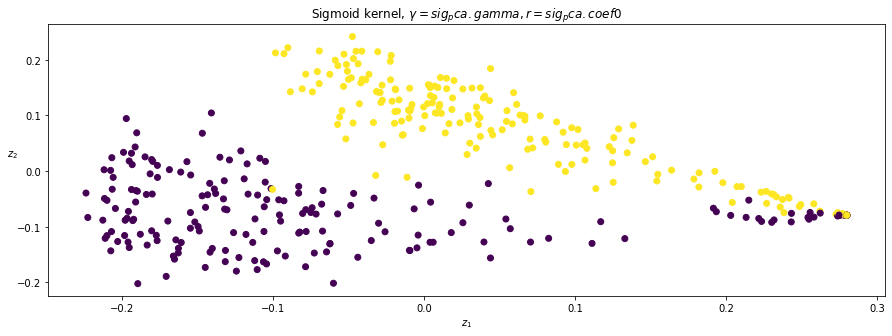

In [5]:
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.0000000001, coef0=1)
plt.figure(figsize=(15, 5))

sig_pca.n_components = 2
sig_pca.random_state = 42
X_reduced = sig_pca.fit_transform(X2)


plt.title("Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$")
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, alpha=1)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.show()

In [10]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

poly_kernel_svm_clf = make_pipeline(StandardScaler(),
                                    SVC(kernel="poly", degree=3, coef0=10, C=100))
poly_kernel_svm_clf.fit(X_reduced, y)

poly_rmse = cross_val_score(poly_kernel_svm_clf, X_reduced, y,
                              scoring="accuracy", cv=20)
poly_rmse

array([0.95      , 0.95      , 0.9       , 0.94736842, 0.78947368,
       0.94736842, 0.94736842, 0.94736842, 0.94736842, 1.        ,
       1.        , 1.        , 0.89473684, 0.89473684, 0.94736842,
       0.94736842, 0.94736842, 1.        , 1.        , 0.94736842])